In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from windrose import WindroseAxes

Matplotlib is building the font cache; this may take a moment.


In [24]:
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

# --- Step 2: Load dataset ---
file_path = '../data/raw/benin-malanville.csv'
df = pd.read_csv(file_path, parse_dates=['Timestamp'])
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [25]:
# --- Step 3: Summary Statistics ---
df.describe(include='all')



,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-02-07 12:00:30.000000512,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
min,2021-08-09 00:01:00,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,2021-11-08 06:00:45,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,2022-02-07 12:00:30,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,2022-05-09 18:00:15,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,2022-08-09 00:00:00,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN
std,NaN,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN


In [ ]:
# --- Missing Values ---
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_report = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_report[missing_report['Missing %'] > 5]

In [26]:
import os
cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# --- Convert numeric safely ---
for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# --- Remove impossible negative solar irradiance values ---
df.loc[df['GHI'] < 0, 'GHI'] = np.nan
df.loc[df['DNI'] < 0, 'DNI'] = np.nan
df.loc[df['DHI'] < 0, 'DHI'] = np.nan

# --- Fill missing values with median (no row drop yet) ---
for c in cols:
    df[c] = df[c].fillna(df[c].median())

# --- Compute Z-scores and flag outliers ---
z_scores = np.abs(stats.zscore(df[cols], nan_policy='omit'))
z_df = pd.DataFrame(z_scores, columns=cols, index=df.index)

outliers = (z_df > 3).sum()
print("Outlier count per column:")
print(outliers)

df['is_outlier'] = (z_df > 3).any(axis=1)
print(f"Total outlier rows flagged: {df['is_outlier'].sum()}")

# --- Optional: Replace outliers with median instead of dropping ---
for c in cols:
    median_val = df[c].median()
    df.loc[df['is_outlier'], c] = median_val

# --- Ensure folder exists and save cleaned data ---
clean_path = '../data/cleaned/benin_clean.csv'
os.makedirs(os.path.dirname(clean_path), exist_ok=True)

print("DataFrame shape before saving:", df.shape)
df.to_csv(clean_path, index=False)
print(f"✅ Cleaned data exported to {os.path.abspath(clean_path)}")

Outlier count per column:
GHI        416
DNI         85
DHI       8628
ModA        27
ModB        63
WS        3109
WSgust    3500
dtype: int64
Total outlier rows flagged: 12920
DataFrame shape before saving: (525600, 20)
✅ Cleaned data exported to d:\AI mastery\solar-challenge-week1\data\cleaned\benin_clean.csv


d:\AI mastery\solar-challenge-week1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


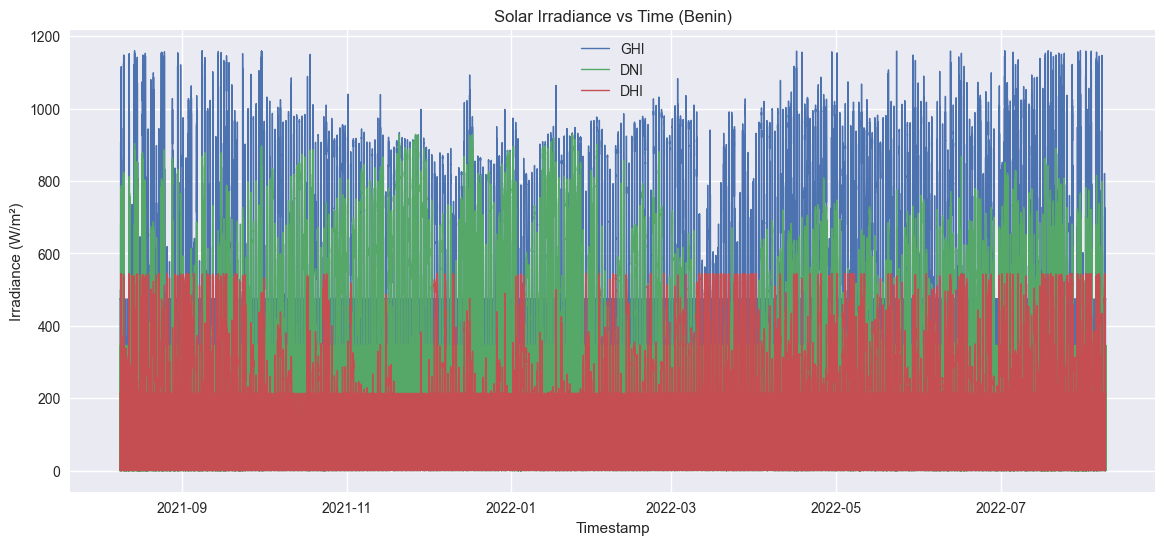

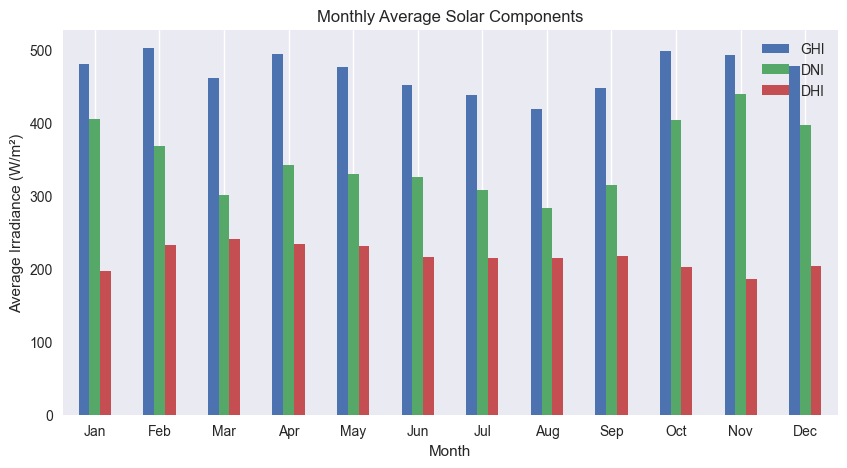

In [27]:


plt.figure(figsize=(14,6))
plt.plot(df['Timestamp'], df['GHI'], label='GHI', linewidth=1)
plt.plot(df['Timestamp'], df['DNI'], label='DNI', linewidth=1)
plt.plot(df['Timestamp'], df['DHI'], label='DHI', linewidth=1)
plt.legend()
plt.title('Solar Irradiance vs Time (Benin)')
plt.xlabel('Timestamp')
plt.ylabel('Irradiance (W/m²)')
plt.grid(True)
plt.show()

# --- Monthly Average Solar Components ---
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df['Month'] = df['Timestamp'].dt.month

# Compute monthly averages
monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI']].mean()

# Optional: Rename months for clarity
month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
               7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_avg.index = monthly_avg.index.map(month_names)

# Plot monthly averages only if data is not empty
if not monthly_avg.empty:
    monthly_avg.plot(kind='bar', figsize=(10,5), title='Monthly Average Solar Components', rot=0)
    plt.xlabel('Month')
    plt.ylabel('Average Irradiance (W/m²)')
    plt.grid(axis='y')
    plt.show()
else:
    print("⚠️ No data available for monthly average plot.")

                ModA        ModB
Cleaning                        
0         221.526670  214.610806
1         304.380206  299.246598


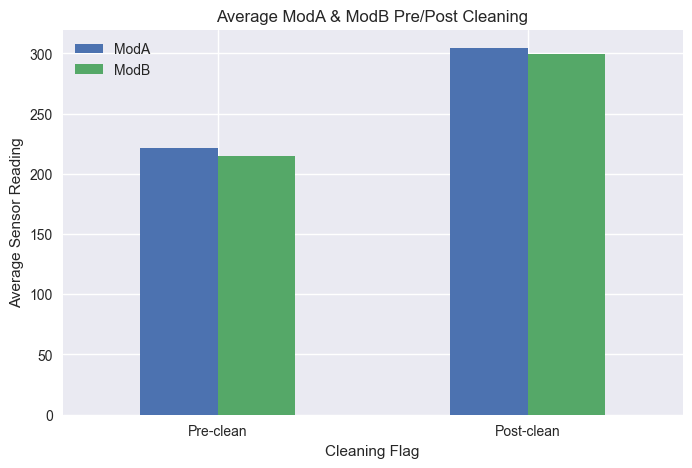

In [28]:
clean_path = '../data/cleaned/benin_clean.csv'
df = pd.read_csv(clean_path)

# --- Ensure numeric columns are properly typed ---
df['ModA'] = pd.to_numeric(df['ModA'], errors='coerce')
df['ModB'] = pd.to_numeric(df['ModB'], errors='coerce')
df['Cleaning'] = pd.to_numeric(df['Cleaning'], errors='coerce')

# --- Fill any missing sensor values with median ---
df['ModA'] = df['ModA'].fillna(df['ModA'].median())
df['ModB'] = df['ModB'].fillna(df['ModB'].median())

# --- Group by Cleaning flag ---
cleaning_group = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
print(cleaning_group)

# --- Plot average ModA & ModB pre/post-clean ---
ax = cleaning_group.plot(kind='bar', figsize=(8,5), rot=0)
ax.set_title('Average ModA & ModB Pre/Post Cleaning')
ax.set_xlabel('Cleaning Flag')
ax.set_ylabel('Average Sensor Reading')
plt.xticks([0,1], ['Pre-clean', 'Post-clean'], rotation=0)
plt.legend(['ModA', 'ModB'])
plt.show()


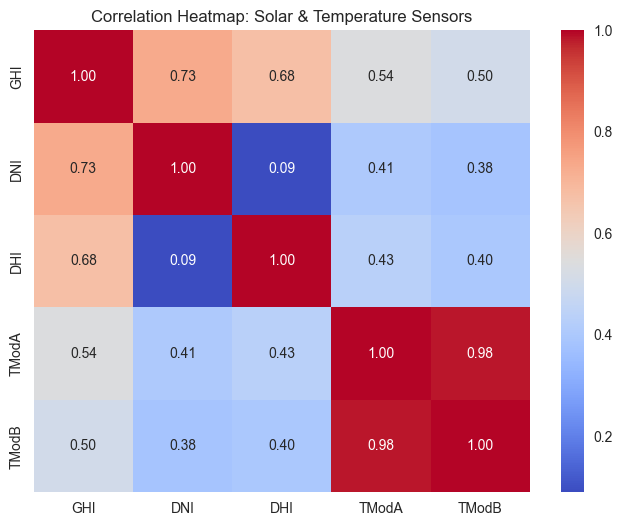

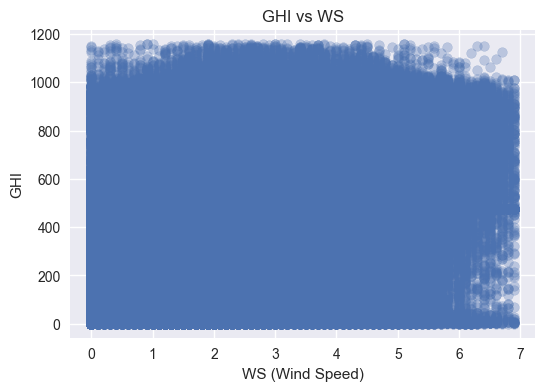

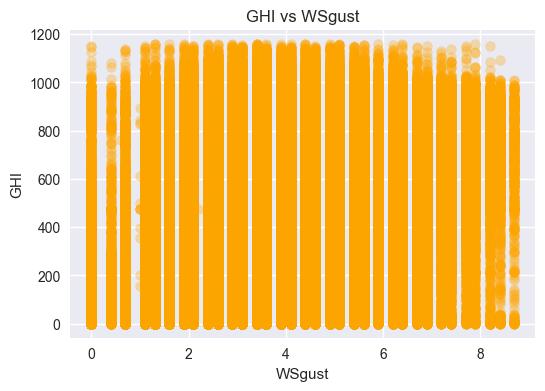

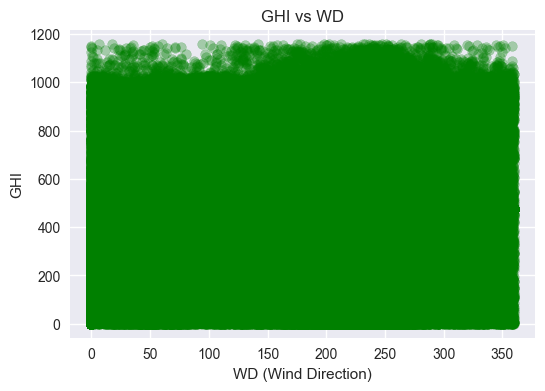

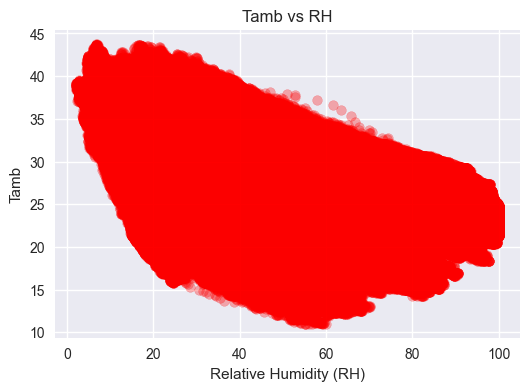

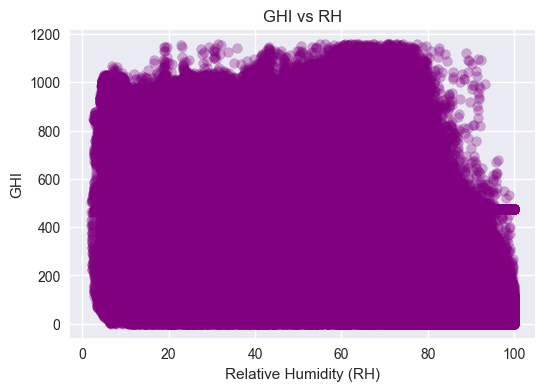

In [29]:
clean_path = '../data/cleaned/benin_clean.csv'
df = pd.read_csv(clean_path)

# --- Ensure numeric columns are numeric ---
numeric_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'WS', 'WSgust', 'WD', 'RH', 'Tamb']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing numeric values for correlation
df_corr = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].dropna()

# --- 1. Heatmap of correlations ---
plt.figure(figsize=(8,6))
corr_matrix = df_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap: Solar & Temperature Sensors')
plt.show()

# --- 2. Scatter plots -- relationships ---

# WS vs GHI
plt.figure(figsize=(6,4))
plt.scatter(df['WS'], df['GHI'], alpha=0.3)
plt.xlabel('WS (Wind Speed)')
plt.ylabel('GHI')
plt.title('GHI vs WS')
plt.show()

# WSgust vs GHI
plt.figure(figsize=(6,4))
plt.scatter(df['WSgust'], df['GHI'], alpha=0.3, color='orange')
plt.xlabel('WSgust')
plt.ylabel('GHI')
plt.title('GHI vs WSgust')
plt.show()

# WD vs GHI
plt.figure(figsize=(6,4))
plt.scatter(df['WD'], df['GHI'], alpha=0.3, color='green')
plt.xlabel('WD (Wind Direction)')
plt.ylabel('GHI')
plt.title('GHI vs WD')
plt.show()

# RH vs Tamb
plt.figure(figsize=(6,4))
plt.scatter(df['RH'], df['Tamb'], alpha=0.3, color='red')
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('Tamb')
plt.title('Tamb vs RH')
plt.show()

# RH vs GHI
plt.figure(figsize=(6,4))
plt.scatter(df['RH'], df['GHI'], alpha=0.3, color='purple')
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('GHI')
plt.title('GHI vs RH')
plt.show()

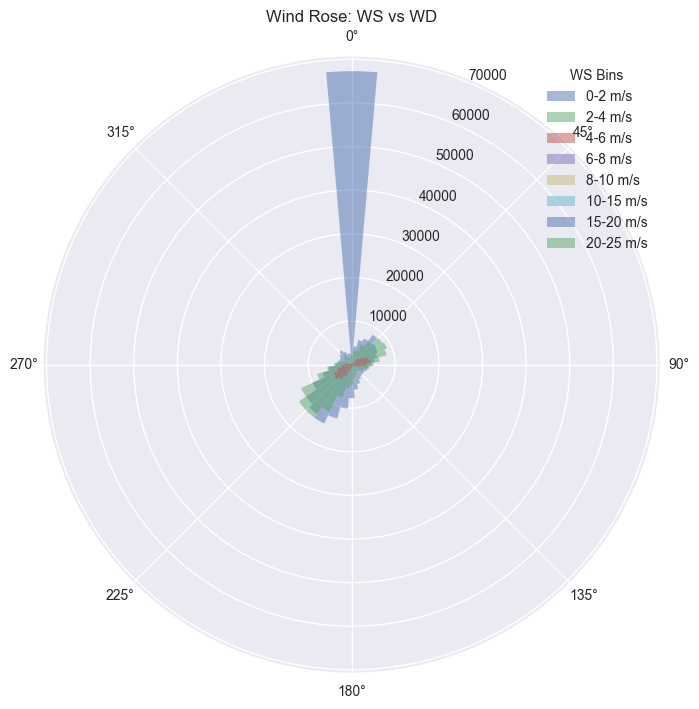

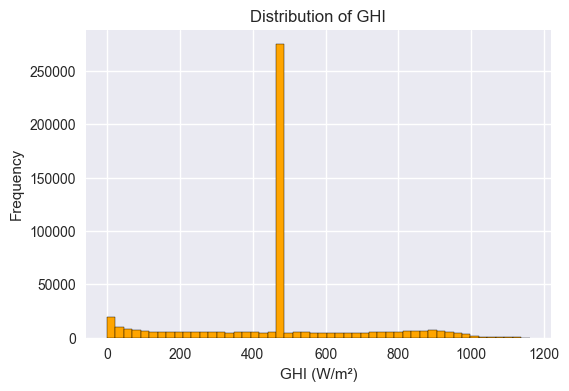

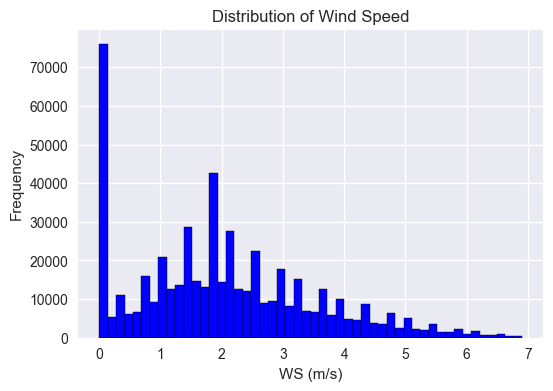

In [30]:
numeric_cols = ['WS', 'WD', 'GHI']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing WS or WD
df_wind = df[['WS', 'WD']].dropna()

# --- 1. Wind rose (radial bar plot) ---
# Convert WD to radians
wd_rad = np.deg2rad(df_wind['WD'])
ws = df_wind['WS']

# Create bins for WS
ws_bins = [0, 2, 4, 6, 8, 10, 15, 20, 25]
ws_labels = range(len(ws_bins)-1)
df_wind['WS_bin'] = pd.cut(ws, bins=ws_bins, labels=ws_labels, right=False)

# Prepare polar plot
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# Aggregate counts by WD and WS_bin
for i in ws_labels:
    ws_subset = df_wind[df_wind['WS_bin'] == i]
    counts, bin_edges = np.histogram(np.deg2rad(ws_subset['WD']), bins=36)
    ax.bar(bin_edges[:-1], counts, width=np.deg2rad(10), bottom=0, alpha=0.5, label=f'{ws_bins[i]}-{ws_bins[i+1]} m/s')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title('Wind Rose: WS vs WD')
plt.legend(title='WS Bins')
plt.show()

# --- 2. Histograms ---

# GHI histogram
plt.figure(figsize=(6,4))
plt.hist(df['GHI'].dropna(), bins=50, color='orange', edgecolor='black')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frequency')
plt.title('Distribution of GHI')
plt.show()

# WS histogram
plt.figure(figsize=(6,4))
plt.hist(df['WS'].dropna(), bins=50, color='blue', edgecolor='black')
plt.xlabel('WS (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Speed')
plt.show()

C:\Users\YASMIN\AppData\Local\Temp\ipykernel_25864\3584782855.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


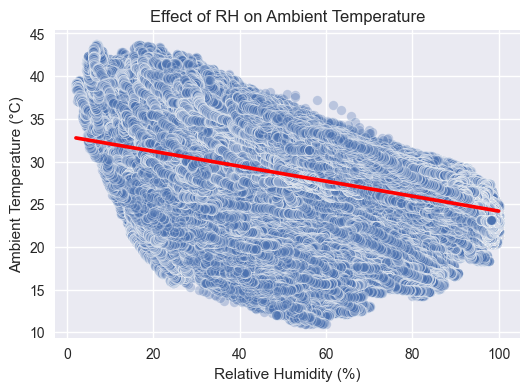

C:\Users\YASMIN\AppData\Local\Temp\ipykernel_25864\3584782855.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


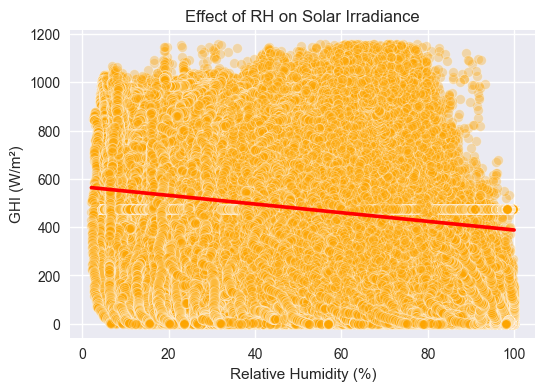

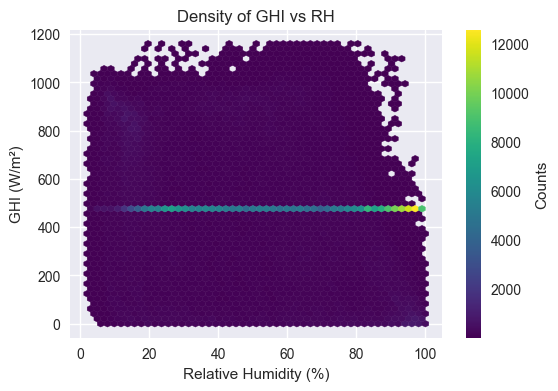

In [31]:
# Ensure numeric columns
numeric_cols = ['Tamb', 'GHI', 'RH']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing values
df_analysis = df[['Tamb', 'GHI', 'RH']].dropna()

# --- 1. Scatter plot: RH vs Tamb ---
plt.figure(figsize=(6,4))
sns.scatterplot(x='RH', y='Tamb', data=df_analysis, alpha=0.3)
sns.regplot(x='RH', y='Tamb', data=df_analysis, scatter=False, color='red', line_kws={'label':'Trend Line'})
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.title('Effect of RH on Ambient Temperature')
plt.legend()
plt.show()

# --- 2. Scatter plot: RH vs GHI ---
plt.figure(figsize=(6,4))
sns.scatterplot(x='RH', y='GHI', data=df_analysis, alpha=0.3, color='orange')
sns.regplot(x='RH', y='GHI', data=df_analysis, scatter=False, color='red', line_kws={'label':'Trend Line'})
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.title('Effect of RH on Solar Irradiance')
plt.legend()
plt.show()

# --- 3. Optional: Hexbin plot for density visualization ---
plt.figure(figsize=(6,4))
plt.hexbin(df_analysis['RH'], df_analysis['GHI'], gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='Counts')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.title('Density of GHI vs RH')
plt.show()

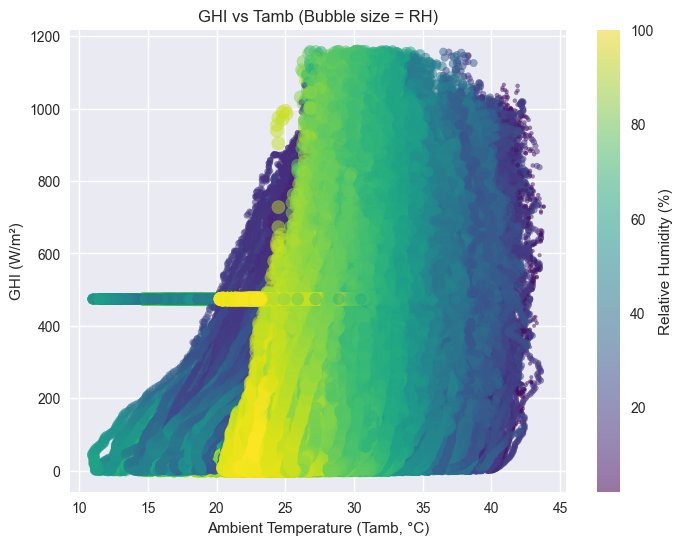

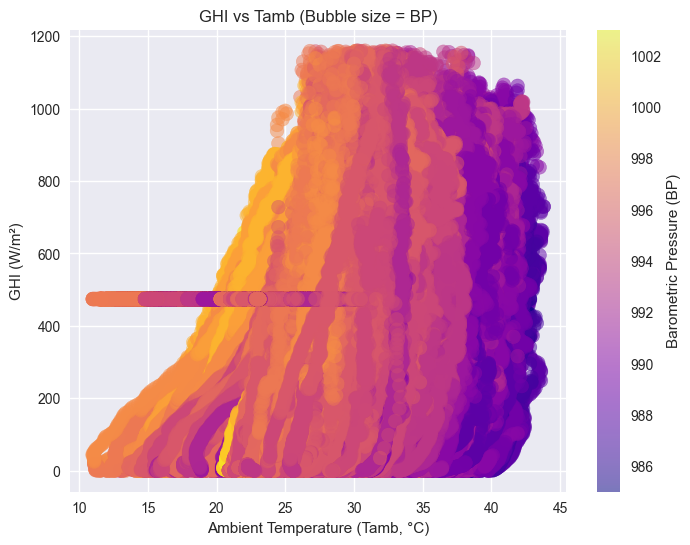

In [32]:
numeric_cols = ['GHI', 'Tamb', 'RH', 'BP']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing values
df_bubble = df[['GHI', 'Tamb', 'RH', 'BP']].dropna()

# --- Bubble Chart: GHI vs Tamb with bubble size = RH ---
plt.figure(figsize=(8,6))
plt.scatter(
    df_bubble['Tamb'], 
    df_bubble['GHI'], 
    s=df_bubble['RH'],  # Bubble size
    c=df_bubble['RH'],  # Bubble color
    cmap='viridis', 
    alpha=0.5
)
plt.xlabel('Ambient Temperature (Tamb, °C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Tamb (Bubble size = RH)')
plt.colorbar(label='Relative Humidity (%)')
plt.show()

# --- Optional: Bubble Chart with BP instead of RH ---
plt.figure(figsize=(8,6))
plt.scatter(
    df_bubble['Tamb'], 
    df_bubble['GHI'], 
    s=(df_bubble['BP']/10),  # Scale down pressure for bubble size
    c=df_bubble['BP'], 
    cmap='plasma', 
    alpha=0.5
)
plt.xlabel('Ambient Temperature (Tamb, °C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Tamb (Bubble size = BP)')
plt.colorbar(label='Barometric Pressure (BP)')
plt.show()